<a href="https://colab.research.google.com/github/hurshd0/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [X] Add your own stretch goal(s) !
- [X] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/hurshd0/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/hurshd0/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a 
# future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')


################################ EDA IMPORTS ###################################
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt # plotting lib
import seaborn as sns # matplotlib wrapper plotting lib
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions

# ---------------- Plot libs settings ------------- #
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
################################################################################

################################ STATS IMPORTS #################################

################################################################################


#################################### ML IMPORTS ################################
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
################################################################################

In [0]:
#### HELPER FUNCTIONS ######

def correlations(data, y, xs):
    from scipy import stats
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

def correlation_heatmap(data=None, vmax=1, annot=True, corr_type='pearson', figsize=(12, 12)):
    if data is None:
        raise ValueError(
            "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    # Taken from the seaborn example at:
    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html
    # Compute the correlation matrix
    corr = data.corr(corr_type)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    fig, axes = plt.subplots(figsize=figsize)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=vmax, annot=annot, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, fmt=',.2f', ax=axes)
    plt.show()
    plt.close()

# LOAD DATESET

In [4]:
def load_nyc_rolling_sales_data(filepath):
    # Read New York City property sales data
    df = pd.read_csv(filepath)

    # Change column names: replace spaces with underscores
    df.columns = [col.replace(' ', '_') for col in df]

    # SALE_PRICE was read as strings.
    # Remove symbols, convert to integer
    df['SALE_PRICE'] = (
        df['SALE_PRICE']
        .str.replace('$','')
        .str.replace('-','')
        .str.replace(',','')
        .astype(int)
    )

    # Keep subset of rows:
    # 1. BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'
    # 2. SALE_PRICE > $100K AND SALE_PRICE < $2M

    mask = (
        (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        ((df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000))
    )
    df = df[mask]

    # Drop unnecessary columns or columns that have > 90% NaNs
    df = df.drop(['ADDRESS', 'BUILDING_CLASS_CATEGORY','EASE-MENT','APARTMENT_NUMBER', 'TAX_CLASS_AT_PRESENT', 'TAX_CLASS_AT_TIME_OF_SALE'], axis=1)

    # Convert SALE_DATE, YEAR_BUILT to datetime
    df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
    df['YEAR_BUILT'] = pd.to_datetime(df['YEAR_BUILT'], infer_datetime_format=True).dt.year

    # Convert LAND_SQUARE_FEET to float
    df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',', '').astype(float)

    # Convert float to int
    float_cols = ['TOTAL_UNITS', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS']
    for col in float_cols:
        df[col] = df[col].astype(int)

    # Convert to categorical
    cat_cols = ['BOROUGH', 'TOTAL_UNITS', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS']
    for col in cat_cols:
        df[col] = df[col].astype(object)
    
    # Map BOROUGHS to their names
    boroughs_name = {1:'MANHATTAN', 2:'BROOKLYN', 3:'QUEENS', 4:'BRONX', 5:'STATEN ISLAND'}
    df['BOROUGH'] = df['BOROUGH'].map(boroughs_name)
    return df
    
raw_df = load_nyc_rolling_sales_data('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3164 entries, 44 to 23035
Data columns (total 15 columns):
BOROUGH                           3164 non-null object
NEIGHBORHOOD                      3164 non-null object
BLOCK                             3164 non-null int64
LOT                               3164 non-null int64
BUILDING_CLASS_AT_PRESENT         3164 non-null object
ZIP_CODE                          3164 non-null float64
RESIDENTIAL_UNITS                 3164 non-null object
COMMERCIAL_UNITS                  3164 non-null object
TOTAL_UNITS                       3164 non-null object
LAND_SQUARE_FEET                  3164 non-null float64
GROSS_SQUARE_FEET                 3164 non-null float64
YEAR_BUILT                        3164 non-null int64
BUILDING_CLASS_AT_TIME_OF_SALE    3164 non-null object
SALE_PRICE                        3164 non-null int64
SALE_DATE                         3164 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), object(7)


In [0]:
# Get Pandas Profiling Report
# raw_df.profile_report()

In [6]:
raw_df.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,QUEENS,OCEAN PARKWAY-NORTH,5495,801,A9,11230.0,1,0,1,6800.0,1325.0,1970,A9,550000,2019-01-01
61,BRONX,QUEENS VILLAGE,7918,72,A1,11427.0,1,0,1,4000.0,2001.0,1970,A1,200000,2019-01-01
78,BROOKLYN,PELHAM PARKWAY SOUTH,4210,19,A1,10461.0,1,0,1,3500.0,2043.0,1970,A1,810000,2019-01-02
108,QUEENS,FLATBUSH-CENTRAL,5212,69,A1,11226.0,1,0,1,4000.0,2680.0,1970,A1,125000,2019-01-02
111,QUEENS,FLATBUSH-EAST,7930,121,A5,11203.0,1,0,1,1710.0,1872.0,1970,A5,620000,2019-01-02


# Split Train-Test

In [7]:
train = raw_df[raw_df['SALE_DATE'] < '2019-04-01']
test = raw_df[raw_df['SALE_DATE'] >= '2019-04-01']
train.shape, test.shape

((2517, 15), (647, 15))

# EDA

## PAIRWISE ANALYSIS


### `GROSS_SQUARE_FEET` vs. `SALE_PRICE` AND `LAND_SQUARE_FEET` vs. `SALE_PRICE`

In [8]:
px.scatter(train, x='GROSS_SQUARE_FEET', y='SALE_PRICE', trendline='lowess')

Notice how `SALE_PRICE` is greater than $0 for `GROSS_SQUARE_FEET == 0`, so we can drop them as they might represent data entry error or placeholder for NaN values.

In [9]:
(train['GROSS_SQUARE_FEET'] == 0).value_counts()

False    2486
True       31
Name: GROSS_SQUARE_FEET, dtype: int64

There are about 31 values that have `0` Gross Square Feet. Let's check if their `LAND_SQUARE_FEET` is 0 as well.

In [10]:
(train['LAND_SQUARE_FEET'] == 0).value_counts()

False    2486
True       31
Name: LAND_SQUARE_FEET, dtype: int64

Let's plot them to see it...

In [11]:
px.scatter(train, x='LAND_SQUARE_FEET', y='SALE_PRICE', trendline='lowess')

Indeed there are 0s for `LAND_SQUARE_FEET` as well, let's see if the rows are the 0 for `GROSS_SQUARE_FEET` as well.

In [12]:
train.query('GROSS_SQUARE_FEET == 0 & LAND_SQUARE_FEET == 0')

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
1135,BRONX,BREEZY POINT,16340,50,A8,11697.0,0,0,0,0.0,0.0,1970,A8,350000,2019-01-08
1403,BRONX,BREEZY POINT,16340,50,A8,11697.0,0,0,0,0.0,0.0,1970,A8,385000,2019-01-09
1990,BRONX,BREEZY POINT,16340,50,A8,11697.0,0,0,0,0.0,0.0,1970,A8,130000,2019-01-11
1991,BRONX,BREEZY POINT,16350,400,A8,11697.0,0,0,0,0.0,0.0,1970,A8,225000,2019-01-11
2469,BROOKLYN,THROGS NECK,5507,1,A8,10465.0,0,0,0,0.0,0.0,1970,A8,328600,2019-01-15
2870,BRONX,BREEZY POINT,16340,50,A8,11697.0,0,0,0,0.0,0.0,1970,A8,500000,2019-01-16
2871,BRONX,BREEZY POINT,16350,300,A8,11697.0,0,0,0,0.0,0.0,1970,A8,250000,2019-01-16
2872,BRONX,BREEZY POINT,16350,400,A8,11697.0,0,0,0,0.0,0.0,1970,A8,400000,2019-01-16
4140,BRONX,BREEZY POINT,16350,400,A8,11697.0,0,0,0,0.0,0.0,1970,A8,277000,2019-01-23
4610,BRONX,BREEZY POINT,16350,400,A8,11697.0,0,0,0,0.0,0.0,1970,A8,450000,2019-01-24


Some of the commonalities are:

- Both have the same neighborhood - `BREEZY POINT` and `THROGS NECK`
- Both have the same block - `2, 4`
- Both have the same `BUILDING_CLASS_AT_PRESENT` and `BUILDING_CLASS_AT_TIME_OF_SALE` - `A8`

In [13]:
# Let's drop them 
train = train[train['GROSS_SQUARE_FEET'] != 0]
test = test[test['GROSS_SQUARE_FEET'] != 0]
train.shape, test.shape

((2486, 15), (637, 15))

### `BOROUGH` vs `PRICE`

In [14]:
train.groupby('BOROUGH')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BOROUGH,,,,,,,,
BRONX,1188.0,651208.525253,290944.370430,100000.0,454057.5,605000.0,818500.0,1876000.0
BROOKLYN,232.0,476628.961207,183582.577398,108000.0,363750.0,470000.0,550000.0,1750000.0
MANHATTAN,1.0,739000.000000,NaN,739000.0,739000.0,739000.0,739000.0,739000.0
QUEENS,401.0,773207.940150,376470.341641,100000.0,522500.0,677500.0,950000.0,2000000.0
STATEN ISLAND,664.0,535988.615964,218433.436923,100000.0,414500.0,518000.0,615750.0,1850000.0


We can see the mean and median sale prices are all different for the boroughs, let's plot them to visualize their difference. 

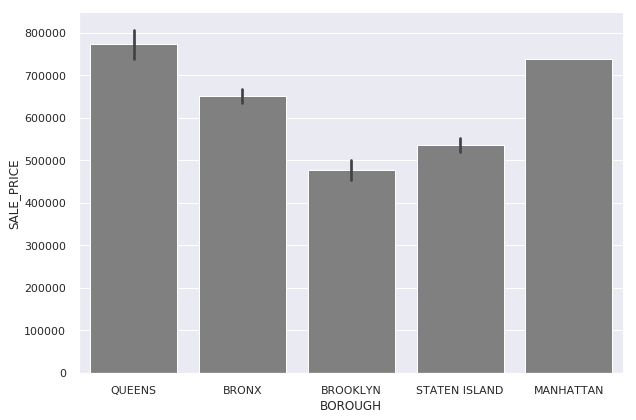

In [15]:
sns.catplot(x='BOROUGH', y='SALE_PRICE', data=train, kind='bar', color='grey', height=6, aspect=1.5);

### `NEIGHBORHOOD` vs. `SALE_PRICE`

In [16]:
train['NEIGHBORHOOD'].value_counts()

FLUSHING-NORTH               78
GREAT KILLS                  69
SPRINGFIELD GARDENS          67
ST. ALBANS                   67
SO. JAMAICA-BAISLEY PARK     64
QUEENS VILLAGE               64
SOUTH OZONE PARK             49
MIDLAND BEACH                49
BAYSIDE                      48
LAURELTON                    48
FLUSHING-SOUTH               45
SOUTH JAMAICA                41
FLATBUSH-EAST                39
ARDEN HEIGHTS                38
ELTINGVILLE                  37
CANARSIE                     37
ROSEDALE                     36
RICHMOND HILL                36
HOLLIS                       36
BAYCHESTER                   35
HOWARD BEACH                 33
CAMBRIA HEIGHTS              32
JACKSON HEIGHTS              28
SOUTH BEACH                  27
WHITESTONE                   27
MARINE PARK                  27
MIDDLE VILLAGE               25
MARINERS HARBOR              25
FLORAL PARK                  25
THROGS NECK                  25
OZONE PARK                   24
MANOR HE

It looks like their is high cardinality in `NEIGHBORHOOD`, we can reduce cardinality by keeping only top 10, and rest grouped as `OTHER`.

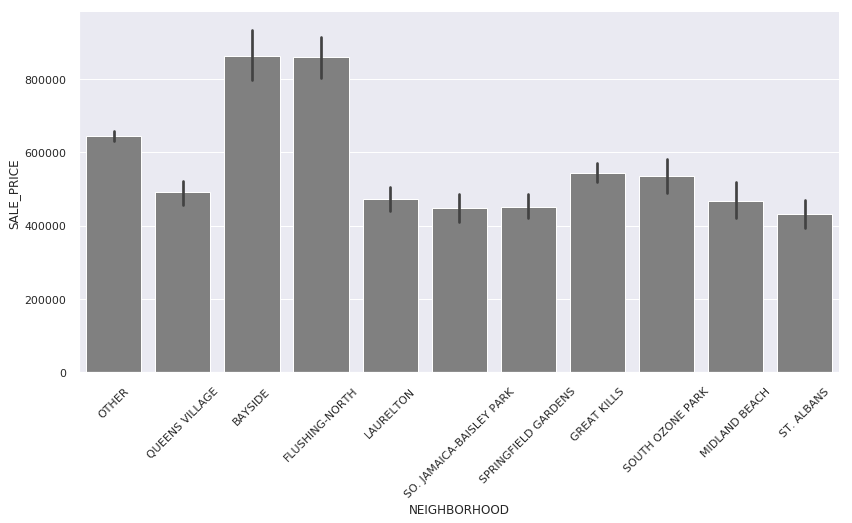

In [17]:
# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# Filter locations based on top10 neighborhoods, and not as OTHERS

train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

sns.catplot(x='NEIGHBORHOOD', y='SALE_PRICE', data=train, color='grey',  kind='bar', height=6, aspect=2);
plt.xticks(rotation=45);

In [18]:
train['NEIGHBORHOOD'].value_counts()

OTHER                       1883
FLUSHING-NORTH                78
GREAT KILLS                   69
ST. ALBANS                    67
SPRINGFIELD GARDENS           67
SO. JAMAICA-BAISLEY PARK      64
QUEENS VILLAGE                64
MIDLAND BEACH                 49
SOUTH OZONE PARK              49
LAURELTON                     48
BAYSIDE                       48
Name: NEIGHBORHOOD, dtype: int64

### `BUILDING_CLASS` vs. `SALE_PRICE`

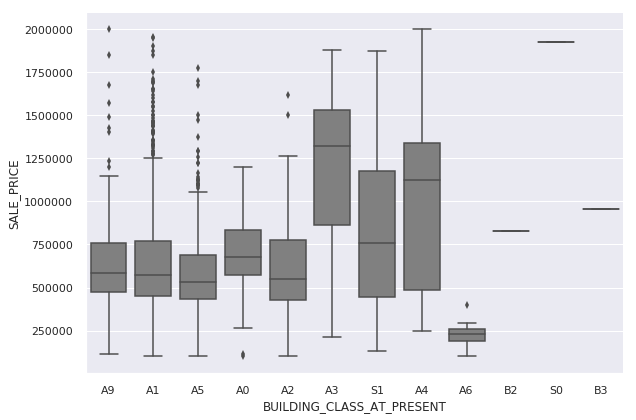

In [19]:
sns.catplot(x='BUILDING_CLASS_AT_PRESENT', y='SALE_PRICE', data=train, kind='box', color='grey', height=6, aspect=1.5);

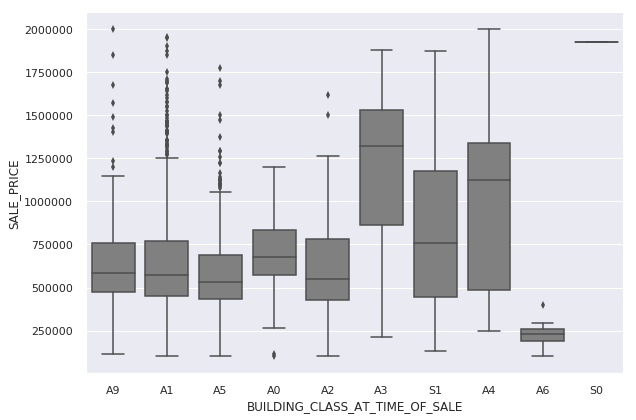

In [20]:
sns.catplot(x='BUILDING_CLASS_AT_TIME_OF_SALE', y='SALE_PRICE', data=train, color='grey', kind='box', height=6, aspect=1.5);

In [21]:
train.groupby('BUILDING_CLASS_AT_TIME_OF_SALE')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BUILDING_CLASS_AT_TIME_OF_SALE,,,,,,,,
A0,67.0,6.884526e+05,221482.552470,104000.0,572500.00,678000.0,833500.0,1200000.0
A1,921.0,6.398825e+05,312379.716631,100000.0,450000.00,570000.0,772500.0,1955000.0
A2,416.0,5.955554e+05,246879.753773,100000.0,425000.00,551000.0,782500.0,1614600.0
A3,38.0,1.199412e+06,433884.919670,211650.0,862966.75,1323560.0,1528750.0,1876000.0
A4,14.0,1.002209e+06,528373.885115,250000.0,484247.50,1126754.0,1338750.0,2000000.0
A5,781.0,5.705963e+05,220638.261466,100000.0,435000.00,532000.0,688888.0,1775000.0
A6,15.0,2.254655e+05,74753.109583,100000.0,188500.00,230000.0,261000.0,399888.0
A9,194.0,6.382551e+05,291090.573816,115000.0,471250.00,583500.0,760000.0,2000000.0
S0,1.0,1.925000e+06,NaN,1925000.0,1925000.00,1925000.0,1925000.0,1925000.0


It would be appropriate to choose `BUILDING_CLASS_AT_TIME_OF_SALE` since, it would the most recent `BUILDING_CLASS` related to `SALE_PRICE`.

Another thing to note is `SALE_PRICE` of:

- `A9`, `A1`, `A5`, `A0`, `A2` are almost similar, mean, and median values compared to `A3`, `A4`, `A6`, `S1` and `S0`.

In [0]:
# Let's group A0, A1, A2, A5, A9 in one group and separate A3, A4, A6, S1 and S0
# TODO

In [23]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    921
A5    781
A2    416
A9    194
A0     67
S1     39
A3     38
A6     15
A4     14
S0      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

### `ZIP_CODE` vs. `SALE_PRICE`

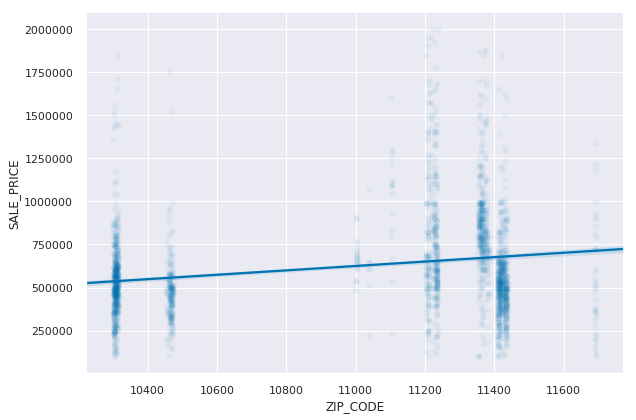

In [24]:
sns.lmplot(x='ZIP_CODE', y='SALE_PRICE', data=train, height=6, aspect=1.5, scatter_kws=dict(alpha=0.05));

It looks like we can bin the zipcodes.

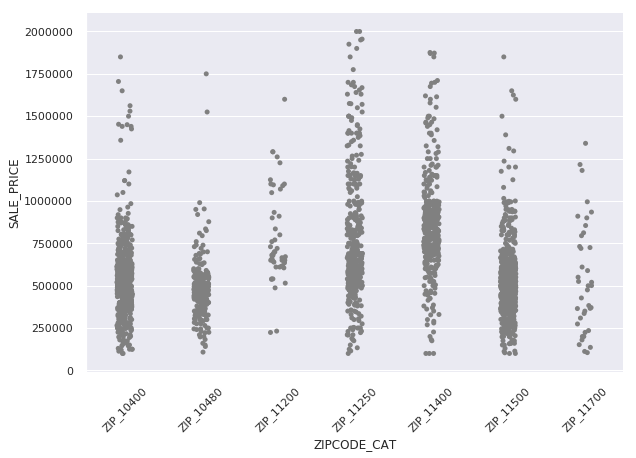

In [25]:
train['ZIPCODE_CAT'] = pd.cut(train['ZIP_CODE'], [0, 10400, 10480, 11200, 11250, 11400, 11500, 11700], right=True, labels=['ZIP_10400', 'ZIP_10480', 'ZIP_11200', 'ZIP_11250', 'ZIP_11400', 'ZIP_11500', 'ZIP_11700'])
test['ZIPCODE_CAT'] = pd.cut(test['ZIP_CODE'], [0, 10400, 10480, 11200, 11250, 11400, 11500, 11700], right=True, labels=['ZIP_10400', 'ZIP_10480', 'ZIP_11200', 'ZIP_11250', 'ZIP_11400', 'ZIP_11500', 'ZIP_11700'])
sns.catplot(x='ZIPCODE_CAT', y='SALE_PRICE', data=train, height=6, aspect=1.5, color='grey')
plt.xticks(rotation=45);

After binning the zipcodes, it looks like the prices are now different with regards to their bins. 

In [0]:
#### DON'T FORGET TO DROP ZIP_CODE ####
train['ZIPCODE_CAT'] = train['ZIPCODE_CAT'].astype(object)
test['ZIPCODE_CAT'] = test['ZIPCODE_CAT'].astype(object)
train = train.drop('ZIP_CODE', axis=1)
test = test.drop('ZIP_CODE', axis=1)

### `YEAR_BUILT` vs. `SALE_PRICE`

In [27]:
train['YEAR_BUILT'].value_counts()

1970    2486
Name: YEAR_BUILT, dtype: int64

Since, all the values are the same we can drop the column.

In [0]:
train = train.drop('YEAR_BUILT', axis=1)
test = test.drop('YEAR_BUILT', axis=1)

### `BLOCK` vs. `SALE_PRICE`

`BLOCK:` 

> A Tax Block is a sub-division of the borough on which real properties are located. The  Department  of  Finance  uses  a  Borough-Block-Lot  classification  to  label  all  real  property  in  the  City.

In [29]:
train['BLOCK'].describe()

count     2486.000000
mean      6674.810539
std       3901.849763
min         21.000000
25%       3809.000000
50%       6019.000000
75%       9605.750000
max      16312.000000
Name: BLOCK, dtype: float64

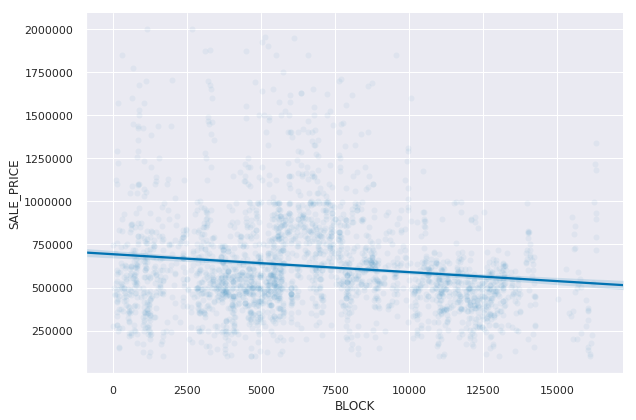

In [30]:
sns.lmplot(x='BLOCK', y='SALE_PRICE', data=train, height=6, aspect=1.5, scatter_kws=dict(alpha=0.05));

It doesn't look like `BLOCK` is a good predictor of `SALE_PRICE`.

### `LOT` vs. `SALE_PRICE`

`LOT:`

> A Tax Lot is a subdivision of a Tax Block and represents the property unique location.

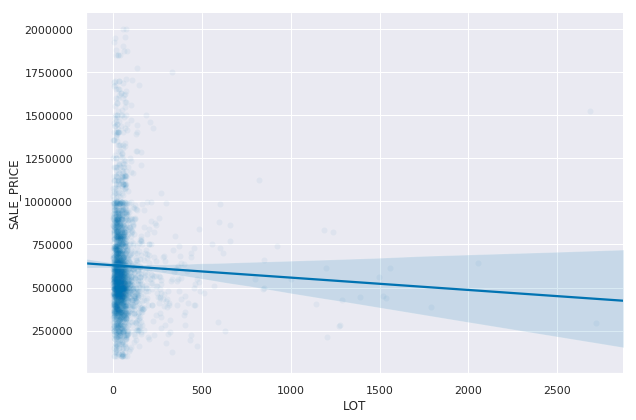

In [31]:
sns.lmplot(x='LOT', y='SALE_PRICE', data=train, height=6, aspect=1.5, scatter_kws=dict(alpha=0.05));

Again, both `BLOCK` and `LOT` are not good predictors of `SALE_PRICE`.

### `TOTAL_UNITS, RESIDENTIAL_UNITS, COMMERCIAL_UNITS vs. SALE_PRICE`

First, let's verify if the `RESIDENTIAL_UNITS` + `COMMERICAL_UNITS` = `TOTAL_UNITS`

if it is, we can just discard other, and keep `TOTAL_UNITS`

In [32]:
(train['RESIDENTIAL_UNITS'] + train['COMMERCIAL_UNITS']).value_counts()

1    2446
2      39
3       1
dtype: int64

In [33]:
train['TOTAL_UNITS'].value_counts()

1    2446
2      39
3       1
Name: TOTAL_UNITS, dtype: int64

Indeed, it is the same, let's keep `TOTAL_UNITS`, and drop the others out.

In [0]:
train = train.drop(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS'], axis=1)
test = test.drop(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS'], axis=1)

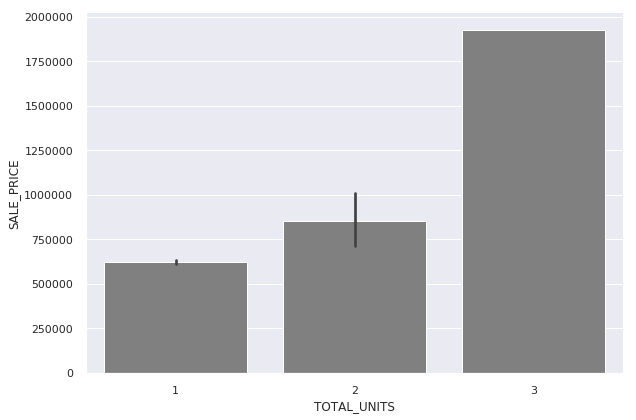

In [35]:
sns.catplot(x='TOTAL_UNITS', y='SALE_PRICE', data=train, kind='bar', color='grey', height=6, aspect=1.5);

We can see `TOTAL_UNITS` is good indicator of `SALE_PRICE`. 

# ONE-HOT ENCODINGS

Let's try out one-hot encodings of chosen cateogrical features:

- `TOTAL_UNITS` 
- `ZIPCODE_CAT`
- `BOROUGH`
- `NEIGHBORHOOD`
- `BUILDING_CLASS_AT_TIME_OF_SALE`


In [36]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
TOTAL_UNITS,2486,3,1,2446,NaN,NaN
BOROUGH,2486,5,BRONX,1188,NaN,NaN
ZIPCODE_CAT,2486,7,ZIP_11500,678,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2486,10,A1,921,NaN,NaN
NEIGHBORHOOD,2486,11,OTHER,1883,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2486,12,A1,921,NaN,NaN
SALE_DATE,2486,68,2019-01-31 00:00:00,77,2019-01-01 00:00:00,2019-03-30 00:00:00


In [37]:
encoder = ce.OneHotEncoder(use_cat_names=True)
cat_features = ['TOTAL_UNITS', 'BOROUGH', 'ZIPCODE_CAT', 'NEIGHBORHOOD', 'BUILDING_CLASS_AT_TIME_OF_SALE']
numeric_features = ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET', 'SALE_PRICE']
combined_features = cat_features + numeric_features
train_encoded = encoder.fit_transform(train[combined_features])
test_encoded = encoder.transform(test[combined_features])
train_encoded.head()

,TOTAL_UNITS_1.0,TOTAL_UNITS_2.0,TOTAL_UNITS_3.0,BOROUGH_QUEENS,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_STATEN ISLAND,BOROUGH_MANHATTAN,ZIPCODE_CAT_ZIP_11250,ZIPCODE_CAT_ZIP_11500,ZIPCODE_CAT_ZIP_10480,ZIPCODE_CAT_ZIP_11400,ZIPCODE_CAT_ZIP_10400,ZIPCODE_CAT_ZIP_11700,ZIPCODE_CAT_ZIP_11200,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_S0,GROSS_SQUARE_FEET,LAND_SQUARE_FEET,SALE_PRICE
44,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1325.0,6800.0,550000
61,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2001.0,4000.0,200000
78,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2043.0,3500.0,810000
108,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2680.0,4000.0,125000
111,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1872.0,1710.0,620000


So, encodings work great, there was no issue with it, let's check correlations.

# CORRELATIONS

Let's summarize what we know so far:

- Good Predictors:
  - `TOTAL_UNITS`
  - `GROSS_SQUARE_FEET` and `LAND_SQUARE_FEET`
  - `BOROUGH`
  - Note sure about `NEIGHBORHOOD`
  - `ZIPCODE_CAT`
  - May be `BUILDING_CLASS_AT_TIME_OF_SALE` if we bin it.


## Correlation Heatmap

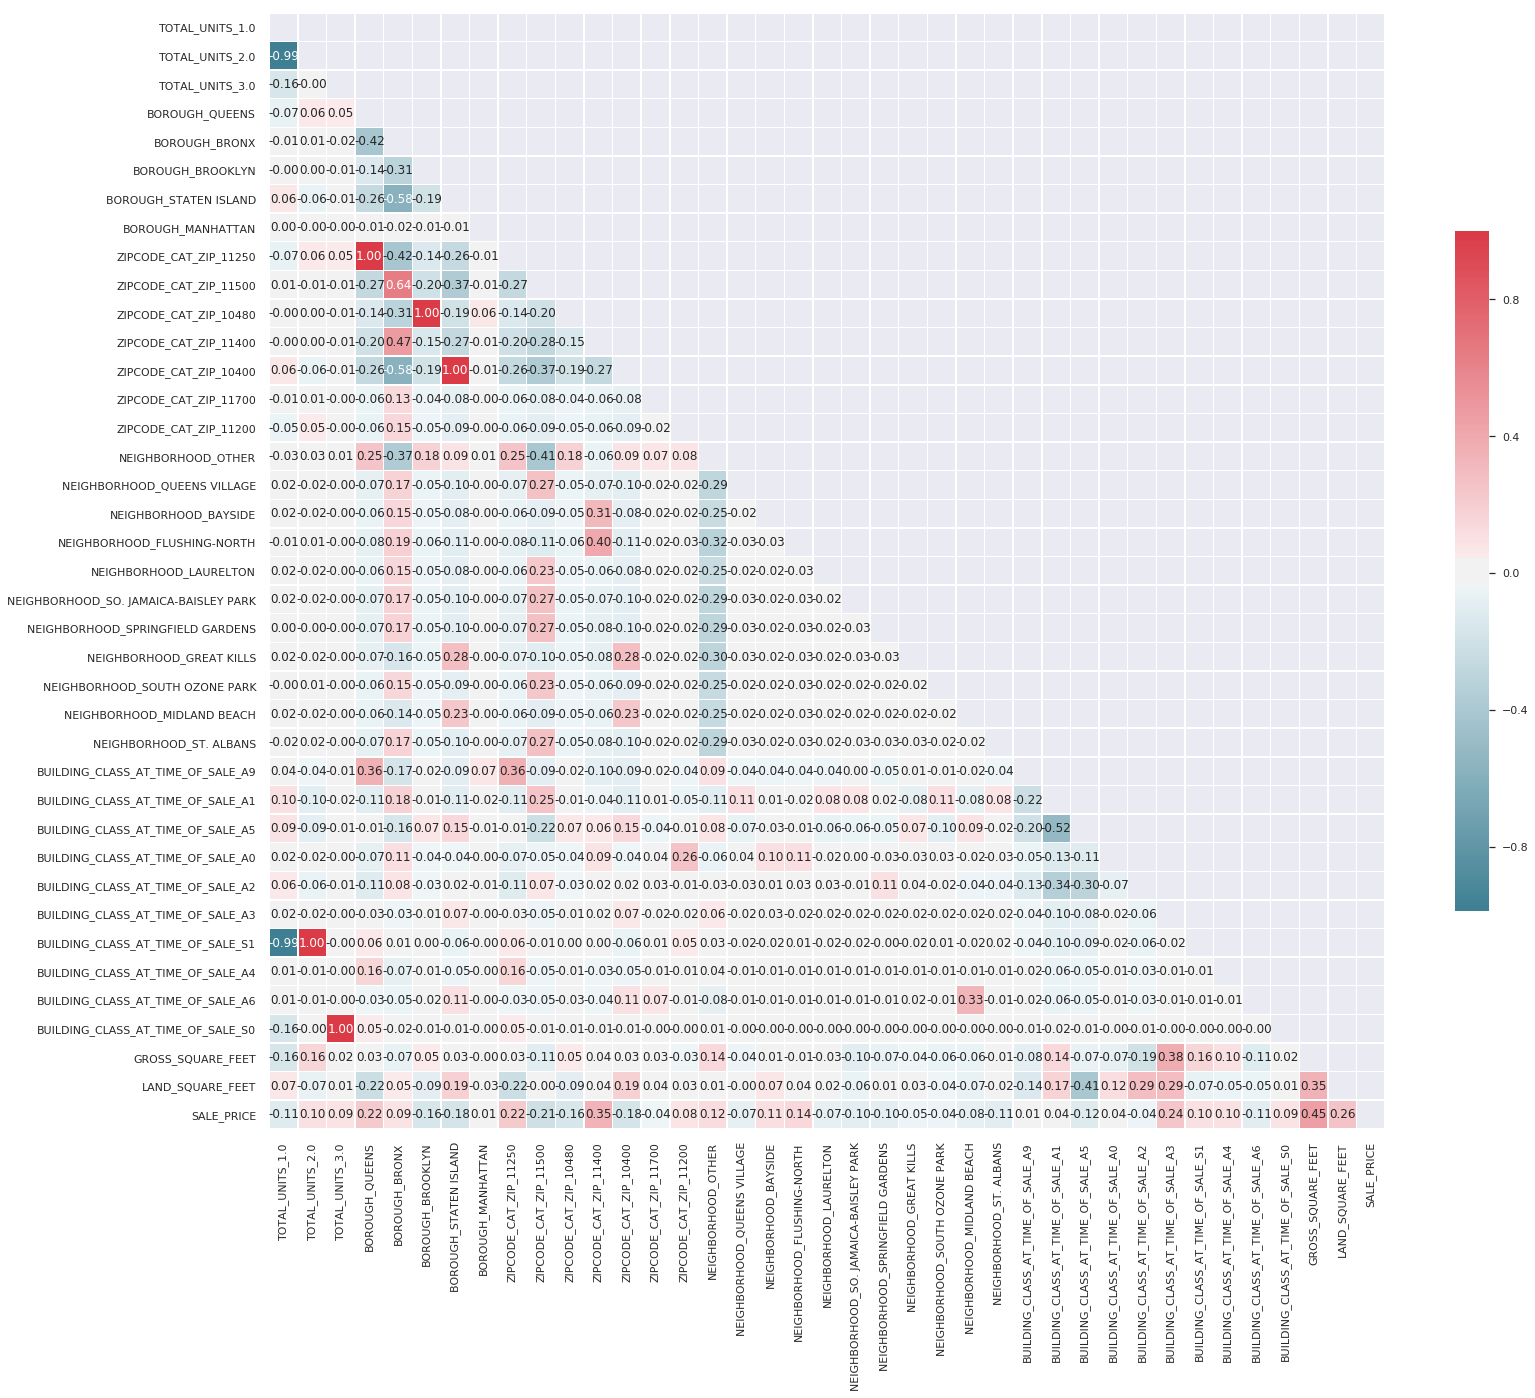

In [38]:
correlation_heatmap(train_encoded, figsize=(25, 25))

### Important Correlations

In [39]:
correlations(train, 'SALE_PRICE', ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET', 'TOTAL_UNITS'])

,feature,r,rho
0,GROSS_SQUARE_FEET,0.449397,0.350964
1,LAND_SQUARE_FEET,0.259799,0.230515
2,TOTAL_UNITS,0.121109,0.057939


# Linear Regression Model

In [0]:
def linear_model_results(data=None, features=None, target=None, one_hot=False, card_n=12, scaling=False, kbest=False, k_val=10, by_date=False, date_col=None, cutoff=None, seed=12345):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    if (features is None) or (not isinstance(features, list)):
        raise ValueError( "The parameter 'features' must be a non-nil reference and list data type")
    if (target is None) or (not isinstance(target, str)):
        raise ValueError( "The parameter 'target' must be a non-nil reference and string object")
    
    # Import to split the data into training/testing sets
    from sklearn.model_selection import train_test_split
    # Import Linear Model
    from sklearn.linear_model import LinearRegression
    # Import metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Extract features 
    if by_date and cutoff and date_col:
        cutoff = pd.to_datetime(cutoff)
        train = data[data[date_col] < cutoff]
        test = data[data[date_col] >= cutoff]
        X_train = train[features]
        y_train = train[target]
        X_test = test[features]
        y_test = test[target]
    else:
        # Train-Test Split
        X = df[features]
        y = df[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)
    
    # One-hot encoding only low card. features
    if one_hot:
        # Check if features have low cardinality otherwise raise error
        if any(X_train.describe(exclude='number').T['unique'] > 12):
            raise ValueError(f'Cannot One-Hot encode, cardinality of one of the feature is greater than set cutoff {card_n}')
        # Import categorical encoder
        import category_encoders as ce
        # Do one-hot encoding
        encoder = ce.OneHotEncoder(use_cat_names=True)
        X_train = encoder.fit_transform(X_train)
        X_test = encoder.transform(X_test)
        # Assert columns are same
        assert X_train.shape[1] == X_test.shape[1]

    # Standard Scaling features
    if scaling:
        # Import standard scaler
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # Assert columns are same
        assert X_train.shape[1] == X_test.shape[1]

    # Select K Best features
    if kbest and k:
        # Select the 10 features that best correlate with the target
        from sklearn.feature_selection import f_regression, SelectKBest
        selector = SelectKBest(score_func=f_regression, k=10)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
        assert X_train.shape[1] == X_test.shape[1]
    
    # Assign empty dictionary to hold results
    results = {}
    results['n'] = data.shape[0]

    # Instantiate Linear Regression Mode
    model = LinearRegression().fit(X_train, y_train)
    # Add model to results
    results['model'] = model
    # Add coefficients to results
    results['coefficients'] = model.coef_[0]

    # Calculate metrics on training data
    # Add R^2 
    results['train_r_squared'] = model.score(X_train, y_train)
    # Predict
    y_train_hat = model.predict(X_train)
    # MSE
    results['train_MSE'] = mean_squared_error(y_train, y_train_hat)
    # RMSE
    results['train_RMSE'] = np.sqrt(results['train_MSE'])
    # MAE
    results['train_MAE'] = mean_absolute_error(y_train, y_train_hat)

    # Calculate metrics on the test data
    # Add R^2 
    results['test_r_squared'] = model.score(X_test, y_test)
    # Predict
    y_test_hat = model.predict(X_test)
    # MSE
    results['test_MSE'] = mean_squared_error(y_test, y_test_hat)
    # RMSE
    results['test_RMSE'] = np.sqrt(results['test_MSE'])
    # MAE
    results['test_MAE'] = mean_absolute_error(y_test, y_test_hat)
    return results


def lmodel(X_train, X_test, y_train, y_test):
    # Instantiate Linear Regression Mode
    model = LinearRegression().fit(X_train, y_train)

    # Store metrics   
    results = {}
    # Add model to results
    results['model'] = model
    
    # Calculate metrics on training data
    # Add R^2 
    results['train_r_squared'] = model.score(X_train, y_train)
    # Predict
    y_train_hat = model.predict(X_train)
    # MSE
    results['train_MSE'] = mean_squared_error(y_train, y_train_hat)
    # RMSE
    results['train_RMSE'] = np.sqrt(results['train_MSE'])
    # MAE
    results['train_MAE'] = mean_absolute_error(y_train, y_train_hat)

    # Calculate metrics on the test data
    # Add R^2 
    results['test_r_squared'] = model.score(X_test, y_test)
    # Predict
    y_test_hat = model.predict(X_test)
    # MSE
    results['test_MSE'] = mean_squared_error(y_test, y_test_hat)
    # RMSE
    results['test_RMSE'] = np.sqrt(results['test_MSE'])
    # MAE
    results['test_MAE'] = mean_absolute_error(y_test, y_test_hat)
    return results


def print_lm(results):
    print("""
    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
    MSE: {:.2f}
    RMSE: {:.2f}
    MAE: ${:.2f}

    Test Set
    R^2: {:.2f} (Explained variance score: 1 is perfect prediction)
    MSE: {:.2f}
    RMSE: {:.2f}
    MAE: ${:.2f}
    """.format(results['train_r_squared'], results['train_MSE'], results['train_RMSE'], results['train_MAE'], results['test_r_squared'], results['test_MSE'], results['test_RMSE'], results['test_MAE']))

## Simple Baseline Model

### @@@ Mean @@@

In [64]:
def baseline_results(y_train, y_test):
    pred = np.mean(y_train)
    diffs = y_test - pred
    sqrd_diffs = diffs ** 2
    mae = sum(abs(diffs))
    mse = sum(sqrd_diffs)
    rmse = mse ** 0.5
    print('''
    MAE:  ${:.2f}
    MSE:  {:.2f}
    RMSE: {:.2f}
    '''.format(mae, mse, rmse))
baseline_results(y_train, y_test)


    MAE:  $135038440.03
    MSE:  58303496943732.57
    RMSE: 7635672.66
    


### IMP. NUMERICAL FEATURES ###

In [41]:
# 1. Extract features
target = 'SALE_PRICE'
features = ['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET']

# 2. Instantiate Linear Regression Model
results = linear_model_results(raw_df, features, target, by_date=True, date_col='SALE_DATE', cutoff='2019-04-01')

print_lm(results)


    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 0.22 (Explained variance score: 1 is perfect prediction)
    MSE: 67640158389.85
    RMSE: 260077.22
    MAE: $190853.14

    Test Set
    R^2: 0.22 (Explained variance score: 1 is perfect prediction)
    MSE: 70877657134.77
    RMSE: 266228.58
    MAE: $183257.47
    


## Complex Linear Regression Model

### 1. Model with One-Hot Encoding

In [42]:
## Subset features, and select target
cat_features = ['TOTAL_UNITS', 'BOROUGH', 'ZIPCODE_CAT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'NEIGHBORHOOD']
numeric_features = ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET']
features = cat_features + numeric_features
target = 'SALE_PRICE'

## Split features to X, y - train, test split
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 1. Do one-hot encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Assert columns are same
assert X_train_encoded.shape[1] == X_test_encoded.shape[1]

results = lmodel(X_train_encoded, X_test_encoded, y_train, y_test)
print_lm(results)


    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 0.46 (Explained variance score: 1 is perfect prediction)
    MSE: 46768514365.95
    RMSE: 216260.29
    MAE: $149201.24

    Test Set
    R^2: -381724010115876544.00 (Explained variance score: 1 is perfect prediction)
    MSE: 34368537150802160792702550016.00
    RMSE: 185387532349945.69
    MAE: $7345321629105.94
    


In [43]:
print('Intercept: ', results['model'].intercept_)
print(pd.Series(results['model'].coef_, X_train_encoded.columns.tolist()).to_string())

Intercept:  7486351642423875.0
TOTAL_UNITS_1.0                         -8.422146e+15
TOTAL_UNITS_2.0                         -3.743176e+15
TOTAL_UNITS_3.0                         -3.743176e+15
BOROUGH_QUEENS                           6.457874e+04
BOROUGH_BRONX                            1.731581e+04
BOROUGH_BROOKLYN                        -1.752612e+05
BOROUGH_STATEN ISLAND                   -7.468719e+04
BOROUGH_MANHATTAN                        1.680537e+05
ZIPCODE_CAT_ZIP_11250                    6.458661e+04
ZIPCODE_CAT_ZIP_11500                   -1.001702e+05
ZIPCODE_CAT_ZIP_10480                   -7.183553e+03
ZIPCODE_CAT_ZIP_11400                    1.588967e+05
ZIPCODE_CAT_ZIP_10400                   -7.468831e+04
ZIPCODE_CAT_ZIP_11700                   -1.636448e+05
ZIPCODE_CAT_ZIP_11200                    1.221966e+05
BUILDING_CLASS_AT_TIME_OF_SALE_A9        9.357940e+14
BUILDING_CLASS_AT_TIME_OF_SALE_A1        9.357940e+14
BUILDING_CLASS_AT_TIME_OF_SALE_A5        9.357940e+

We can see that intercetp and coefficients are really large values, which affects the models ability to predict, so let's try removing the least likely predictor from the categorical columns.

In [44]:
cat_features = ['TOTAL_UNITS', 'BOROUGH', 'ZIPCODE_CAT', 'BUILDING_CLASS_AT_TIME_OF_SALE']
numeric_features = ['GROSS_SQUARE_FEET', 'LAND_SQUARE_FEET']
features = cat_features + numeric_features
target = 'SALE_PRICE'

## Split features to X, y - train, test split
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 1. Do one-hot encoding
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Assert columns are same
assert X_train_encoded.shape[1] == X_test_encoded.shape[1]

print('-'*80)
print(f"Training Set Shape: {X_train_encoded.shape}, Test Set Shape: {X_test_encoded.shape}")
print('-'*80)

results = lmodel(X_train_encoded, X_test_encoded, y_train, y_test)
print_lm(results)

--------------------------------------------------------------------------------
Training Set Shape: (2486, 27), Test Set Shape: (637, 27)
--------------------------------------------------------------------------------

    ----------- Linear Regression Model Results -------------
    Training Set
    R^2: 0.45 (Explained variance score: 1 is perfect prediction)
    MSE: 47533222818.63
    RMSE: 218021.15
    MAE: $150426.35

    Test Set
    R^2: 0.39 (Explained variance score: 1 is perfect prediction)
    MSE: 55299095852.17
    RMSE: 235157.60
    MAE: $160628.66
    


> Looks like `NEIGHBORHOOD` is a bad predictor, let's remove it, and may be it is conflicting with `ZIPCODE_CAT` and `BOROUGH`.

### 2. Model with Select K Best features

In [45]:
## 2. Select K Best features
# Select the 10 features that best correlate with the target
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_test_selected = selector.transform(X_test_encoded)
assert X_train_selected.shape[1] == X_test_selected.shape[1]

# Which features were selected?
all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

print('-'*80)
print(f"Training Set Shape: {X_train_selected.shape}, Test Set Shape: {X_test_selected.shape}")
print('-'*80)

results = lmodel(X_train_selected, X_test_selected, y_train, y_test)
print_lm(results)

Features selected:
BOROUGH_QUEENS
BOROUGH_BROOKLYN
BOROUGH_STATEN ISLAND
ZIPCODE_CAT_ZIP_11250
ZIPCODE_CAT_ZIP_11500
ZIPCODE_CAT_ZIP_11400
ZIPCODE_CAT_ZIP_10400
BUILDING_CLASS_AT_TIME_OF_SALE_A3
GROSS_SQUARE_FEET
LAND_SQUARE_FEET

Features not selected:
TOTAL_UNITS_1.0
TOTAL_UNITS_2.0
TOTAL_UNITS_3.0
BOROUGH_BRONX
BOROUGH_MANHATTAN
ZIPCODE_CAT_ZIP_10480
ZIPCODE_CAT_ZIP_11700
ZIPCODE_CAT_ZIP_11200
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_S0
--------------------------------------------------------------------------------
Training Set Shape: (2486, 10), Test Set Shape: (637, 10)
--------------------------------------------------------------------------------

    ----------- Linear Regression Model Results -------------
    Trainin

Looks like Top 10 features have **Location** and **Sq. ft.** information in common.

### 3. Loop through and find k-best feature

In [56]:
def find_k_best_features(X_train, X_test, y_train, y_test):
    for k in range(1, len(X_train.columns)+1):
        print(f'{k} features')
        selector = SelectKBest(score_func=f_regression, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)    
        model = LinearRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r_square = model.score(X_test_selected, y_test)
        print('''
        R^2: {:.2f}
        MSE: {:.2f}
        RMSE: {:.2f}
        MAE: ${:.2f}
        '''.format(r_square, mse, rmse, mae))


find_k_best_features(X_train_encoded, X_test_encoded, y_train, y_test)

1 features

        R^2: 0.19
        MSE: 72763551515.88
        RMSE: 269747.20
        MAE: $186993.23
        
2 features

        R^2: 0.27
        MSE: 66073511001.47
        RMSE: 257047.68
        MAE: $166245.50
        
3 features

        R^2: 0.28
        MSE: 64615160855.17
        RMSE: 254195.12
        MAE: $161760.50
        
4 features

        R^2: 0.29
        MSE: 64336870540.70
        RMSE: 253647.14
        MAE: $161563.74
        
5 features

        R^2: 0.38
        MSE: 55591957877.15
        RMSE: 235779.47
        MAE: $160860.12
        
6 features

        R^2: 0.38
        MSE: 55591957877.16
        RMSE: 235779.47
        MAE: $160860.12
        
7 features

        R^2: 0.39
        MSE: 55295906629.03
        RMSE: 235150.82
        MAE: $159893.02
        
8 features

        R^2: 0.39
        MSE: 55235368862.75
        RMSE: 235022.06
        MAE: $159960.52
        
9 features

        R^2: 0.39
        MSE: 55203242468.21
        RMSE: 234953.7

It looks like when **k == 7** the MAE dropped to `$159893.02`, than it starts increasing with higher k, while RMSE keeps dropping further than starts increasing, so the sweet spot for k features looks to be around 7-9.

# MAKE PIPELINE

We will do the same thing we did above but concise way, and organize the code while we do it.

In [67]:
# KBest was k=7, so I will pick 7

############# Import Scikit-learn pipeline #############
from sklearn.pipeline import make_pipeline
############# Import regression models #############
from sklearn.linear_model import LinearRegression
############# Import pre-processing classes #############
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_validate
from category_encoders import OneHotEncoder
############# Import metrics #############
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pipln = make_pipeline(OneHotEncoder(use_cat_names=True), SelectKBest(score_func=f_regression, k=7),
                        LinearRegression())

# Fit model
pipln.fit(X_train, y_train)
# Get score
r_square = pipln.score(X_test, y_test)
# Get predictions
y_pred = pipln.predict(X_test)
# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('''
R^2: {:.2f}
MSE: {:.2f}
RMSE: {:.2f}
MAE: ${:.2f}
'''.format(r_square, mse, rmse, mae))



R^2: 0.39
MSE: 55295906629.03
RMSE: 235150.82
MAE: $159893.02

